In [2]:
import matplotlib as mpl
import numpy as np
from matplotlib.font_manager import FontProperties

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 设置中文字体
# 方法1：使用系统中已有的中文字体
fonts = [f.name for f in fm.fontManager.ttflist if '微软雅黑' in f.name or 'SimHei' in f.name or 'SimSun' in f.name or 'Microsoft YaHei' in f.name]
if fonts:
    plt.rcParams['font.family'] = fonts[0]
    print(f"使用字体: {fonts[0]}")
else:
    # 方法2：使用matplotlib内置的中文字体支持
    plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans', 'Arial Unicode MS']
    plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
    print("使用默认中文字体配置")

使用字体: Microsoft YaHei


# 模型评估

在本Notebook中，我们将对训练好的MNIST模型进行评估，比较使用Adam和SGD优化器训练的模型的性能。

使用设备: cpu
Successfully downloaded MNIST dataset using torchvision
Test accuracy: 99.04%


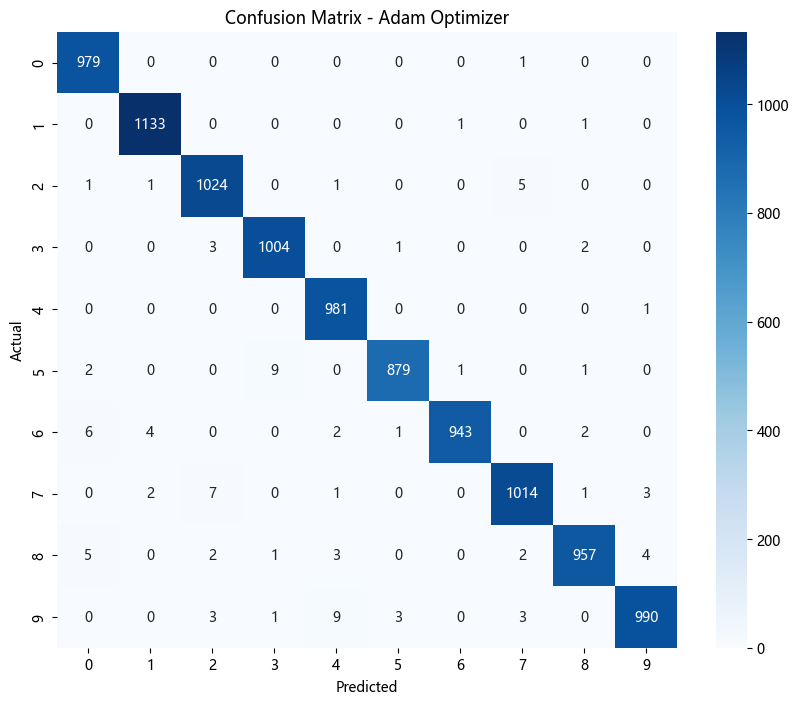

Successfully downloaded MNIST dataset using torchvision
Test accuracy: 98.17%


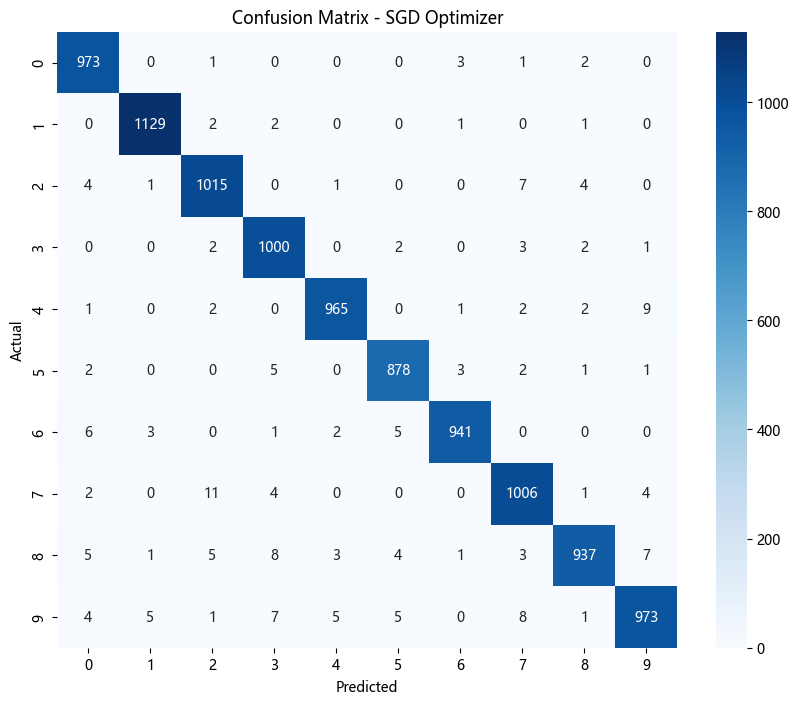

Improved 模型测试准确率: 99.51%

优化器性能对比:
Adam优化器准确率: 99.04%
SGD优化器准确率: 98.17%
改进模型准确率: 99.51%
准确率差异 (Improved - Adam): 0.47%
准确率差异 (Improved - SGD): 1.34%


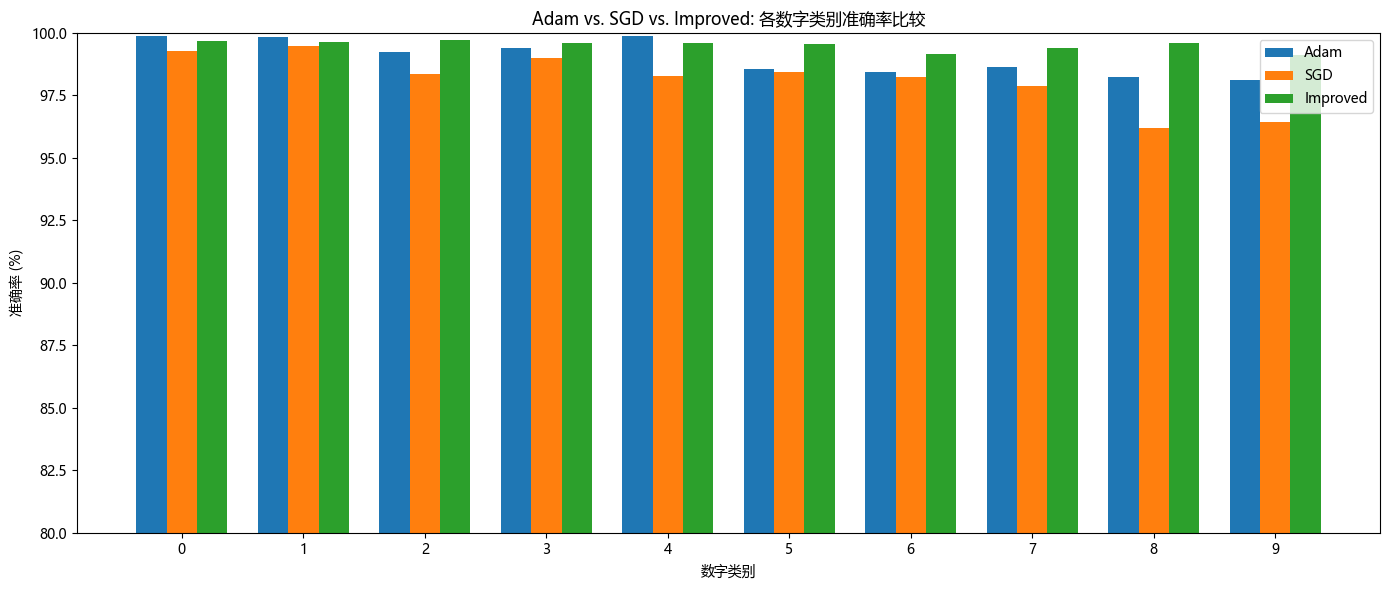

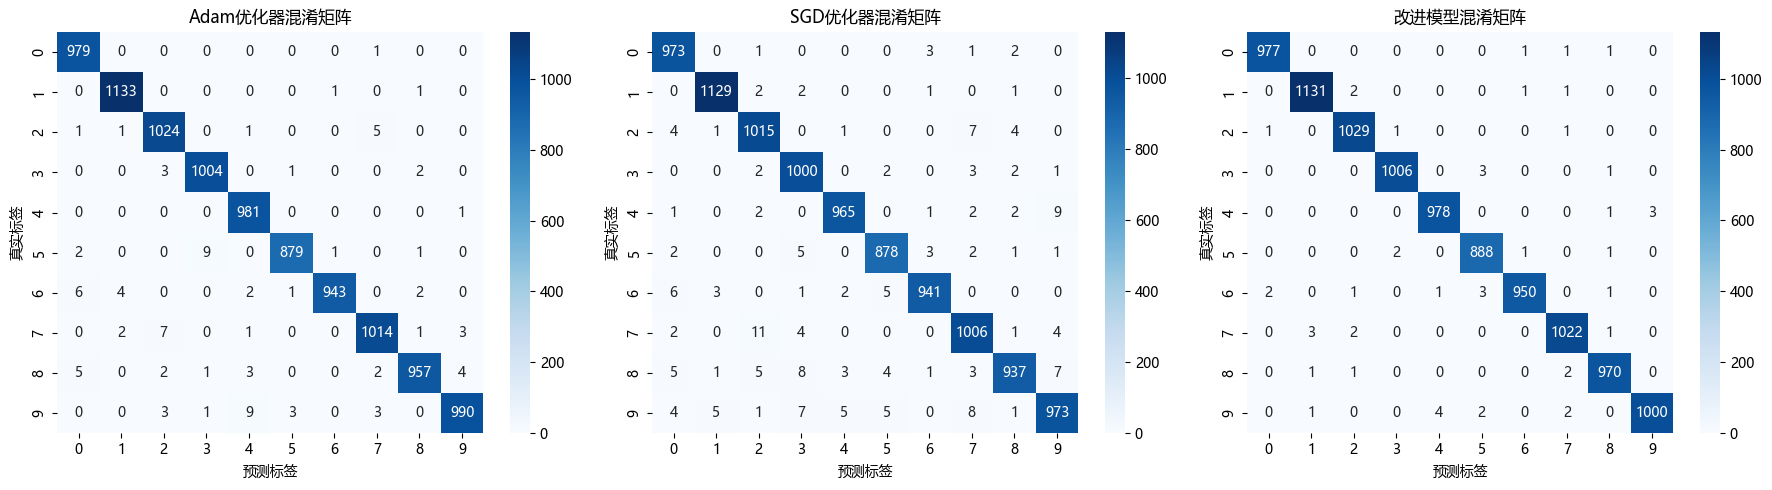

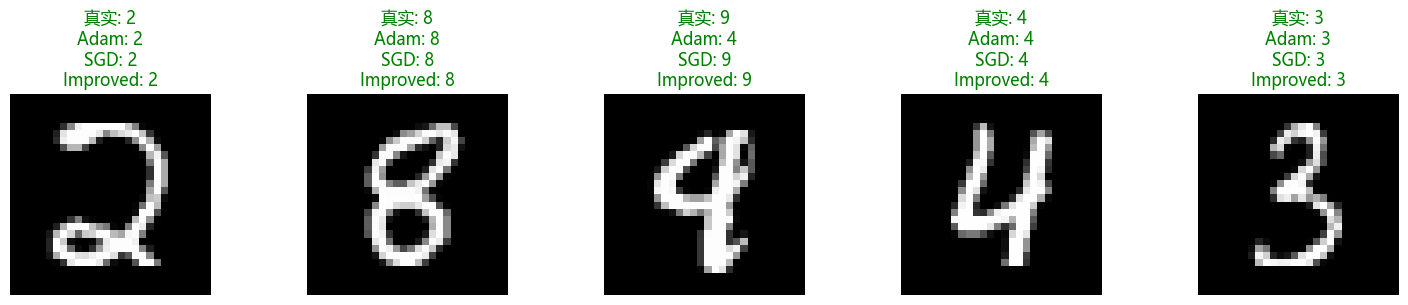

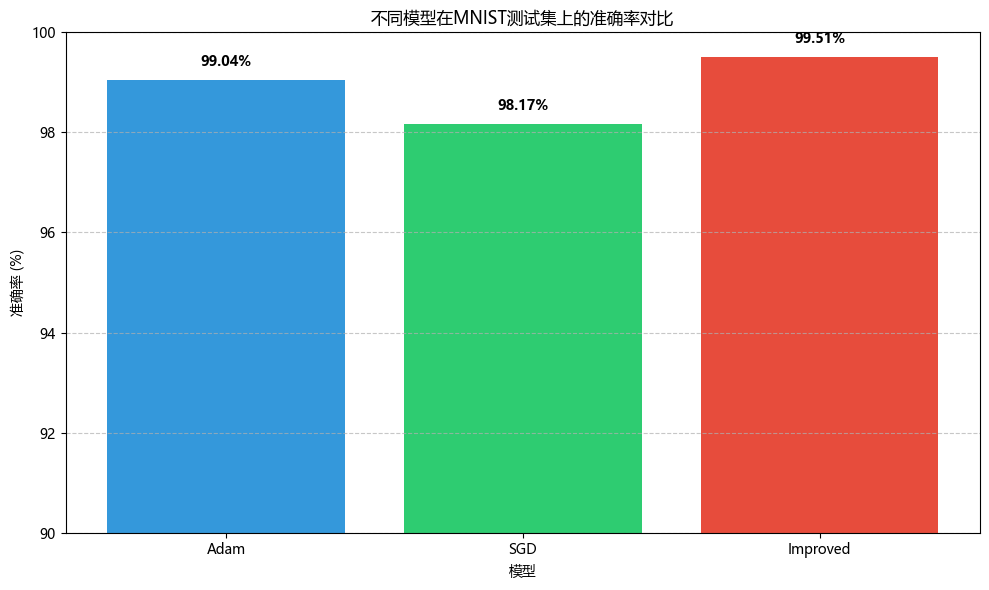

In [14]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import os
import sys

# 添加项目根目录到路径
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
project_root = os.path.dirname(notebook_dir)
sys.path.append(project_root)

# 导入顺序很重要，确保Python能找到模块
from src.models.mnist_cnn import MNIST_CNN
from src.models.mnist_cnn_improved import MNIST_CNN_Improved  # 确保此文件存在
from src.test_model import test_model

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 数据预处理
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# 加载测试数据集（从项目根目录的data文件夹）
data_dir = os.path.join(project_root, "data")
test_dataset = datasets.MNIST(data_dir, train=False, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# 构建模型路径（使用项目根目录的saved_models文件夹）
saved_models_dir = os.path.join(project_root, "saved_models")
adam_model_path = os.path.join(saved_models_dir, "mnist_Adam.pt")
sgd_model_path = os.path.join(saved_models_dir, "mnist_SGD.pt")
improved_model_path = os.path.join(saved_models_dir, "mnist_cnn_improved.pt")

# 测试Adam优化器模型
adam_model, adam_accuracy, adam_predictions, adam_true_labels, adam_conf_mat = test_model(adam_model_path, "Adam")

# 测试SGD优化器模型
sgd_model, sgd_accuracy, sgd_predictions, sgd_true_labels, sgd_conf_mat = test_model(sgd_model_path, "SGD")

# 在笔记本中直接定义测试改进模型的函数，避免导入问题
def test_improved_model(model_path, model_name):
    """
    测试改进版模型并返回准确率和预测结果
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 使用改进版 MNIST_CNN_Improved 模型
    model = MNIST_CNN_Improved().to(device)
    
    # 加载模型权重
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    # 测试模型
    correct = 0
    total = 0
    all_predictions = []
    all_true_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:  # 使用上面定义的test_loader
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # 收集预测结果和真实标签
            all_predictions.extend(predicted.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())
    
    accuracy = 100 * correct / total
    print(f"{model_name} 模型测试准确率: {accuracy:.2f}%")
    
    # 创建混淆矩阵
    conf_mat = confusion_matrix(all_true_labels, all_predictions)
    
    return model, accuracy, all_predictions, all_true_labels, conf_mat

# 使用新函数测试改进版模型
improved_model, improved_accuracy, improved_predictions, improved_true_labels, improved_conf_mat = test_improved_model(improved_model_path, "Improved")

# 比较三个模型的性能
print("\n优化器性能对比:")
print(f"Adam优化器准确率: {adam_accuracy:.2f}%")
print(f"SGD优化器准确率: {sgd_accuracy:.2f}%")
print(f"改进模型准确率: {improved_accuracy:.2f}%")
print(f"准确率差异 (Improved - Adam): {improved_accuracy - adam_accuracy:.2f}%")
print(f"准确率差异 (Improved - SGD): {improved_accuracy - sgd_accuracy:.2f}%")

# 可视化对比不同类别的准确率
def compare_class_accuracy(adam_conf, sgd_conf, improved_conf):
    adam_class_acc = [adam_conf[i,i]/np.sum(adam_conf[i])*100 for i in range(10)]
    sgd_class_acc = [sgd_conf[i,i]/np.sum(sgd_conf[i])*100 for i in range(10)]
    improved_class_acc = [improved_conf[i,i]/np.sum(improved_conf[i])*100 for i in range(10)]
    
    plt.figure(figsize=(14, 6))
    x = np.arange(10)
    width = 0.25
    
    plt.bar(x - width, adam_class_acc, width, label='Adam')
    plt.bar(x, sgd_class_acc, width, label='SGD')
    plt.bar(x + width, improved_class_acc, width, label='Improved')
    
    plt.xlabel('数字类别')
    plt.ylabel('准确率 (%)')
    plt.title('Adam vs. SGD vs. Improved: 各数字类别准确率比较')
    plt.xticks(x, range(10))
    plt.ylim(80, 100)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 比较各类别准确率
compare_class_accuracy(adam_conf_mat, sgd_conf_mat, improved_conf_mat)

# 可视化各模型的混淆矩阵
def plot_confusion_matrices(adam_conf, sgd_conf, improved_conf):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Adam混淆矩阵
    sns.heatmap(adam_conf, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_xlabel('预测标签')
    axes[0].set_ylabel('真实标签')
    axes[0].set_title('Adam优化器混淆矩阵')
    
    # SGD混淆矩阵
    sns.heatmap(sgd_conf, annot=True, fmt='d', cmap='Blues', ax=axes[1])
    axes[1].set_xlabel('预测标签')
    axes[1].set_ylabel('真实标签')
    axes[1].set_title('SGD优化器混淆矩阵')
    
    # 改进模型混淆矩阵
    sns.heatmap(improved_conf, annot=True, fmt='d', cmap='Blues', ax=axes[2])
    axes[2].set_xlabel('预测标签')
    axes[2].set_ylabel('真实标签')
    axes[2].set_title('改进模型混淆矩阵')
    
    plt.tight_layout()
    plt.show()

# 绘制混淆矩阵
plot_confusion_matrices(adam_conf_mat, sgd_conf_mat, improved_conf_mat)

# 可视化一些测试样例(同时显示三个模型的预测结果)
def visualize_samples_comparison(adam_model, sgd_model, improved_model, device, test_loader, num_samples=5):
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    
    sample_indices = torch.randint(0, len(images), (num_samples,))
    sample_images = images[sample_indices].to(device)
    sample_labels = labels[sample_indices]
    
    adam_outputs = adam_model(sample_images)
    _, adam_predicted = torch.max(adam_outputs, 1)
    
    sgd_outputs = sgd_model(sample_images)
    _, sgd_predicted = torch.max(sgd_outputs, 1)
    
    improved_outputs = improved_model(sample_images)
    _, improved_predicted = torch.max(improved_outputs, 1)
    
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(sample_images[i].cpu().squeeze(), cmap='gray')
        correct_count = (adam_predicted[i] == sample_labels[i]).item() + \
                        (sgd_predicted[i] == sample_labels[i]).item() + \
                        (improved_predicted[i] == sample_labels[i]).item()
        
        # 根据预测正确性设置标题颜色
        title_color = 'green' if improved_predicted[i] == sample_labels[i] else 'red'
        
        plt.title(f"真实: {sample_labels[i]}\nAdam: {adam_predicted[i].cpu().item()}\nSGD: {sgd_predicted[i].cpu().item()}\nImproved: {improved_predicted[i].cpu().item()}",
                 color=title_color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_samples_comparison(adam_model, sgd_model, improved_model, device, test_loader)

# 添加模型准确率柱状图比较
def plot_model_accuracy_comparison(adam_acc, sgd_acc, improved_acc):
    models = ['Adam', 'SGD', 'Improved']
    accuracies = [adam_acc, sgd_acc, improved_acc]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(models, accuracies, color=['#3498db', '#2ecc71', '#e74c3c'])
    
    # 在柱状图上显示准确率值
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2., acc + 0.2, 
                f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.xlabel('模型')
    plt.ylabel('准确率 (%)')
    plt.title('不同模型在MNIST测试集上的准确率对比')
    plt.ylim(90, 100)  # 调整Y轴范围以便更好地显示差异
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# 绘制模型准确率比较图
plot_model_accuracy_comparison(adam_accuracy, sgd_accuracy, improved_accuracy)